# New York taxi trips duration

The objective of this kernel is to better understand and explain some useful techniques of exploratory data analysis(EDA) and try to achieve a good performance in training,testing, and submiting a outcome to kaggle competition. for the sake of doing that, we are going to use the New York City Trip Duration competition ,you guys can find the complete briefing of it by clicking <a href="https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview">Here</a> .

Required datasets:
* <a href="https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data" >Download Taxi City Trip Duration Dataset</a>
* <a href = "https://drive.google.com/file/d/1WIWwC4F3ITnuW7xk0hPomQgYq35OVsaN/view?usp=sharing">Complementary Dataset of Taxi Trips</a>
* <a href = "https://drive.google.com/file/d/1kfRBRtaX-g8HjGvY3kmoWIu2H3x4_ZHE/view?usp=sharing">Weather dataset of New York in 2016</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost
from math import radians, cos, sin, asin, sqrt

Importing the required datasets with pandas.read_csv()

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

fast1_train = pd.read_csv('Data/fastest_routes_train_part_1.csv')
fast2_train = pd.read_csv('Data/fastest_routes_train_part_2.csv')
fast_test = pd.read_csv('Data/fastest_routes_test.csv')
weather = pd.read_csv('Data/weather_data_nyc_centralpark_2016.csv')

In [3]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

Parsing datetime

In [4]:
train['date'] = [i.date() for i in train.pickup_datetime]
train['date'] = pd.to_datetime(train.date)

train['year'] = [date.year for date in train.date]
train['month'] = [date.month for date in train.date]
train['day'] = [date.day for date in train.date]
train['dow'] = [date.dayofweek for date in train.date]
train['hour'] = [date.hour for date in train.pickup_datetime]


test['date'] = [i.date() for i in test.pickup_datetime]
test['date'] = pd.to_datetime(test.date)

test['year'] = [date.year for date in test.date]
test['month'] = [date.month for date in test.date]
test['day'] = [date.day for date in test.date]
test['dow'] = [date.dayofweek for date in test.date]
test['hour'] = [date.hour for date in test.pickup_datetime]

Parsing the weather dataset and merging it with the train and test dataframes

In [5]:
weather['date'] = pd.to_datetime(weather.date)

for column in weather.dtypes[weather.dtypes == np.object].index:
    weather.loc[:,column].replace('T',0.05,inplace = True)
    weather.loc[:,column] = weather.loc[:,column].astype(np.float32)

weather_features = ['average temperature','precipitation','snow fall','snow depth','date']

train = pd.merge(train,weather.loc[:,weather_features],on = 'date')
test = pd.merge(test,weather.loc[:,weather_features],on = 'date')

C:\Users\Nicholas\AppData\Local\Temp\ipykernel_9880\1541704187.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for column in weather.dtypes[weather.dtypes == np.object].index:


Parsing the fastest routes dataset and merging it with our dataframes as well

In [6]:
drop_cols = ['travel_time_per_step','distance_per_step','step_maneuvers','step_direction','step_location_list','starting_street','end_street','street_for_each_step','number_of_steps']
fastest = pd.concat([fast1_train,fast2_train],ignore_index = True)

# Train
fastest.drop(axis=1 , columns = drop_cols,inplace = True)
train = pd.merge(train,fastest,on = 'id')

# Test
fast_test.drop(axis=1 , columns = drop_cols,inplace = True)
test = pd.merge(test,fast_test,on = 'id')

train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,day,dow,hour,average temperature,precipitation,snow fall,snow depth,total_distance,total_travel_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,3,14,0,17,45.5,0.29,0.0,0.0,2009.1,164.9
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,3,14,0,14,45.5,0.29,0.0,0.0,2782.9,244.6
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,3,14,0,15,45.5,0.29,0.0,0.0,3124.4,419.9


We have parsed our data, so lets start some EDA .

<b>First we are gonna group our dataset weekly</b>

In [7]:
group1 = train.groupby('date')['precipitation','snow depth','total_distance','total_travel_time','dow','passenger_count'].mean()
group1.reset_index(inplace = True)
group2 = train.groupby('date').size()
group2 = group2.reset_index()
group2.columns = ['date','trips']

grouped = pd.merge(group1,group2,on = 'date') ## Week
grouped.head(3)

C:\Users\Nicholas\AppData\Local\Temp\ipykernel_9880\1880812847.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group1 = train.groupby('date')['precipitation','snow depth','total_distance','total_travel_time','dow','passenger_count'].mean()


,date,precipitation,snow depth,total_distance,total_travel_time,dow,passenger_count,trips
0,2016-01-01,0.00,0.0,5143.794373,421.080704,4.0,1.797961,7162
1,2016-01-02,0.01,2.0,4765.598050,398.939542,5.0,1.792230,6512
2,2016-01-03,0.00,0.0,5319.785314,433.265575,6.0,1.737919,6353


<b>Ok, we have it, now we can add somemore fancy look to our EDA by grouping some interest variables by Hour</b>

In [8]:
group_hour1 = train.groupby('hour')['precipitation','snow depth','total_distance','total_travel_time','passenger_count'].mean()
group_hour1.reset_index(inplace = True)
group_hour2 = train.groupby('hour').size()
group_hour2 = group_hour2.reset_index()
group_hour2.columns = ['hour','trips']

grouped_hour = pd.merge(group_hour1,group_hour2,on = 'hour') ## Hour
grouped_hour.head(3)

C:\Users\Nicholas\AppData\Local\Temp\ipykernel_9880\2439587877.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_hour1 = train.groupby('hour')['precipitation','snow depth','total_distance','total_travel_time','passenger_count'].mean()


,hour,precipitation,snow depth,total_distance,total_travel_time,passenger_count,trips
0,0,0.103397,0.334159,5362.671852,450.913193,1.690974,53248
1,1,0.104693,0.346414,5249.464655,448.558497,1.709393,38571
2,2,0.102259,0.313018,5142.919208,446.297354,1.704740,27972


In [9]:
## Hour and Day of Week
dowh1 = train.groupby(['dow','hour'])['precipitation','snow depth','total_distance','total_travel_time','passenger_count'].mean()
dowh2 = train.groupby(['dow','hour']).size()
dowh2.name = 'Trips'

dowh = pd.concat([dowh1,dowh2],axis= 1)

trips_hm = dowh2.unstack(level = 1)

am = trips_hm.iloc[:,:12]
pm = trips_hm.iloc[:,12:]

C:\Users\Nicholas\AppData\Local\Temp\ipykernel_9880\3754038409.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dowh1 = train.groupby(['dow','hour'])['precipitation','snow depth','total_distance','total_travel_time','passenger_count'].mean()


## Number of Travels relantionships

First thing first, what is more important in a Taxi travels dataset more then the number of trips ? So we can start by plotting the mean of the number of trips occorrued in eachday of week,and week hour of the day to see how it looks like.

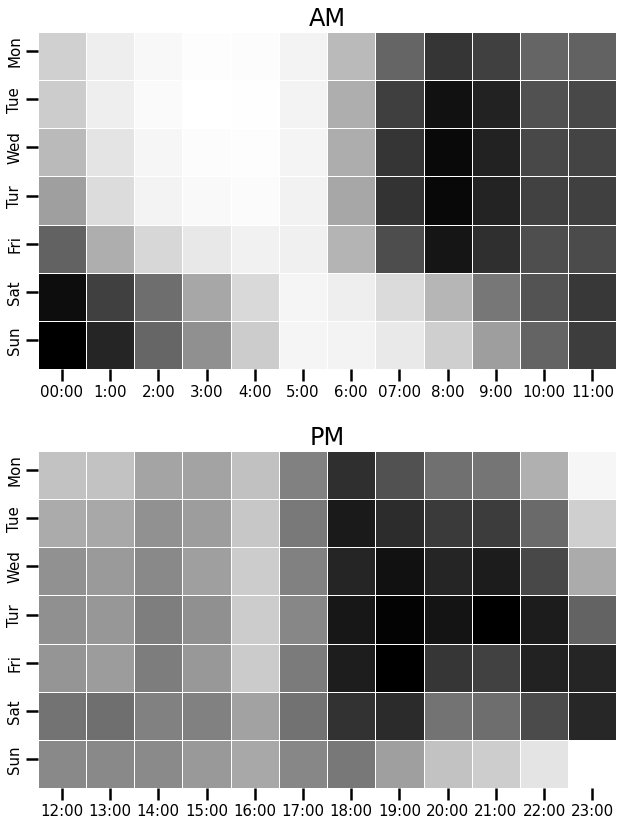

In [23]:
sns.set_context('poster')

fig,axes  = plt.subplots(2,figsize = (14,12))

sns.heatmap(am,square = True,cbar = False,linewidths = 1,cmap = 'Greys',ax = axes[0],annot=False,annot_kws = {'fontsize':12})
axes[0].set_title('AM')
axes[0].set_yticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4])
axes[0].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
axes[0].set_xticklabels(['00:00','1:00','2:00','3:00','4:00','5:00','6:00','07:00','8:00','9:00','10:00','11:00'])
axes[0].set_yticklabels(['Mon','Tue','Wed','Tur','Fri','Sat','Sun'])
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].tick_params(labelsize=15)

sns.heatmap(pm,square = True,cbar = False,linewidths = 1,cmap = 'Greys',ax = axes[1],annot = False,annot_kws = {'fontsize':12})
axes[1].set_title('PM')
axes[1].set_yticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4])
axes[1].set_yticklabels(['Mon','Tue','Wed','Tur','Fri','Sat','Sun'])
axes[1].set_ylabel('')
axes[1].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
axes[1].set_xticklabels(['12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00'])
axes[1].set_xlabel('')
axes[1].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

Nice, now we can see that when people are going to work (between 7:00 and 9:00) the number of taxi trips ramped up, as well as in hours when people are going back to their home after work (between 18:00 and 20:00) . Also is interesting to see how taxi trips are demanded in the weekends after 23:00, we have no doubt that people like to hang out and meet their friends very often in the weekend's nights .

## Handling Outliers

Unfortunatelly our dataset dont have a real confident variable to represent real state of traffic jam, but we can use some feature engineering to create something that can serve as a proxy,that is, something that can represent traffic jam, in order to do that we can use the average speed, in wich we can estimate by dividing the average distance by the average trip duration , so lets do it .

In [25]:
train['trafficjam'] = (train.total_distance/train.trip_duration*-1)+3453

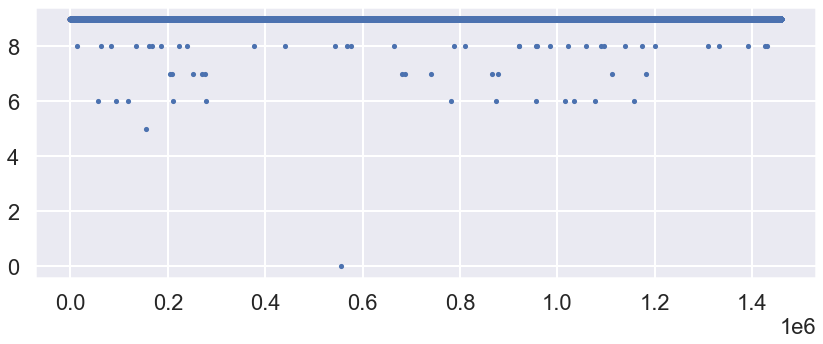

In [26]:
sns.set()
sns.set_context('poster',font_scale = 1)
plt.figure(figsize = (14,5))
bins = pd.cut(train.trafficjam,10,labels = False)
plt.scatter(y = bins,x = range(bins.size),s = 10)
plt.show()

It looks like we have some outliers here, they represent 1200 points in our dataset of 1.400.000 datapoints, for the sake of this analysis they are not valid and can interfere badly in our analysis, so lets get rid of them assign them the value of the mean .

In [27]:
## Handling outliers
train.trafficjam[np.abs(train.trafficjam - train.trafficjam.mean()) > (train.trafficjam.std()*3)].size

## Assign mean to them
train.loc[np.abs(train.trafficjam - train.trafficjam.mean()) > (train.trafficjam.std()*3),'trafficjam'] = train.trafficjam.mean()

## Traffic Jam relantionships
Now we can indeed se how our traffic jam variable behave by plotting it

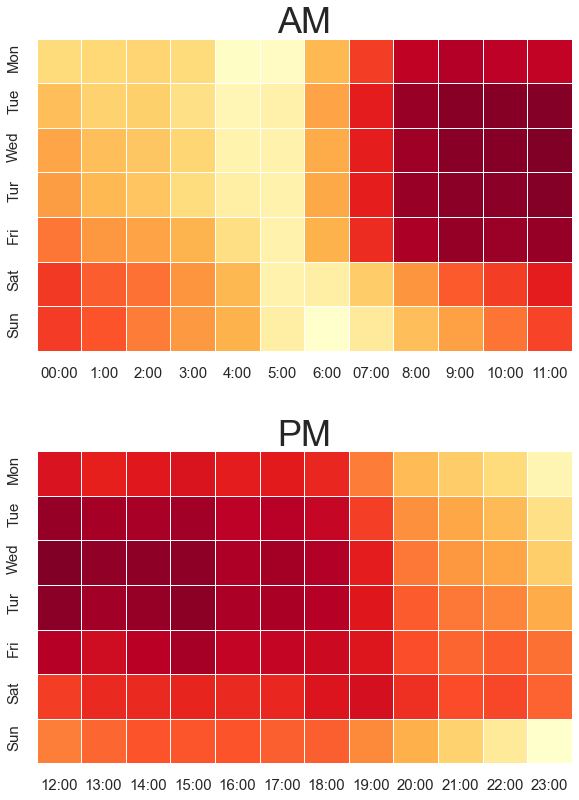

In [28]:
dh_traffic = train.groupby(['dow','hour'])['trafficjam'].mean()
dh_traffic = dh_traffic.unstack(level = 1)

am = dh_traffic.iloc[:,:12]
pm = dh_traffic.iloc[:,12:]

fig,axes = plt.subplots(2,figsize = (12,12))
sns.set_context('poster',font_scale = 1.5)

sns.heatmap(am,square = True,cbar = False,linewidths = 1,cmap = 'YlOrRd',ax = axes[0],annot=False,annot_kws = {'fontsize':10},fmt = 'g')
axes[0].set_title('AM')
axes[0].set_yticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4])
axes[0].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
axes[0].set_xticklabels(['00:00','1:00','2:00','3:00','4:00','5:00','6:00','07:00','8:00','9:00','10:00','11:00'])
axes[0].set_yticklabels(['Mon','Tue','Wed','Tur','Fri','Sat','Sun'])
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].tick_params(labelsize=15)

sns.heatmap(pm,square = True,cbar = False,linewidths = 1,cmap = 'YlOrRd',ax = axes[1],annot = False,annot_kws = {'fontsize':10},fmt = 'g')
axes[1].set_title('PM')
axes[1].set_yticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4])
axes[1].set_yticklabels(['Mon','Tue','Wed','Tur','Fri','Sat','Sun'])
axes[1].set_ylabel('')
axes[1].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
axes[1].set_xticklabels(['12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00'])
axes[1].set_xlabel('')
axes[1].tick_params(labelsize=15)

plt.tight_layout()
plt.show()

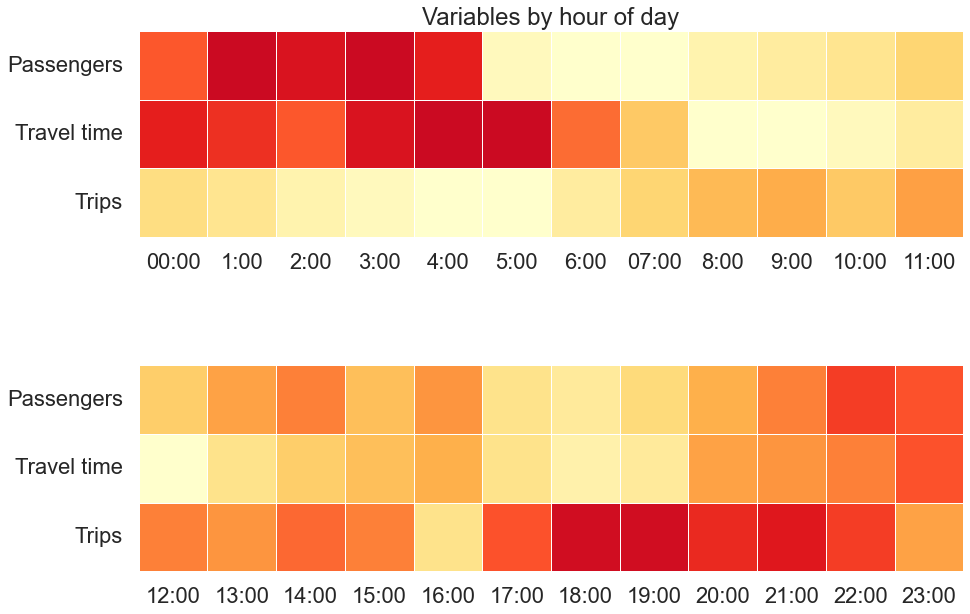

In [29]:
## DAY OF WEEK VARIABLES


features = ['passenger_count','total_travel_time','trips']
sgh = grouped_hour.loc[:,features+['hour']]

for feature in features:
    sgh[str(feature)+'_score'] = pd.qcut(sgh[feature],20,labels = False)
sgh = sgh.drop(columns = ['passenger_count','total_travel_time','trips'])

sgh.loc[:,sgh.columns != 'hour'] = sgh.loc[:,sgh.columns != 'hour'] +1 ## Verificar depois

am = sgh[sgh.hour < 12]
pm = sgh[sgh.hour >= 12]
am.set_index('hour',inplace = True)
pm.set_index('hour',inplace = True)


sns.set_context('poster')

fig,axes  = plt.subplots(2,figsize = (14,10))

axes[0].set_title('Variables by hour of day')
sns.heatmap(am.T,square = True,cbar = False,linewidths = 1,cmap = 'YlOrRd',ax = axes[0],annot=False,annot_kws = {'fontsize':15},vmax = 24)
axes[0].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
axes[0].set_xticklabels(['00:00','1:00','2:00','3:00','4:00','5:00','6:00','07:00','8:00','9:00','10:00','11:00'])
axes[0].set_xlabel('')
axes[0].set_yticks([0.5,1.5,2.5])
axes[0].set_yticklabels(['Passengers','Travel time','Trips'])

sns.heatmap(pm.T,square = True,cbar = False,linewidths = 1,cmap = 'YlOrRd',ax = axes[1],annot = False,annot_kws = {'fontsize':15},vmax = 24)
axes[1].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
axes[1].set_xticklabels(['12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00'])
axes[1].set_xlabel('')
axes[1].set_yticks([0.5,1.5,2.5])
axes[1].set_yticklabels(['Passengers','Travel time','Trips'])
plt.tight_layout()
plt.show()

## Correlation map

A correlation map (aka. correlation matrix) is a very handful tool when dealing with large number of variables. it shows us lots of meaningful information about our dataset and its relationships. In this case, as expected we can se a great correlation between total_travel_time and total_distance, but besides it, we will have to explore better our dataset to understand its relationships and what kind of variables are useful to predict the total travel time.

In order to do that we are going to explore better the features and make some feature engineering as we are gonna see further.

C:\Users\Nicholas\AppData\Local\Temp\ipykernel_14704\3609321936.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


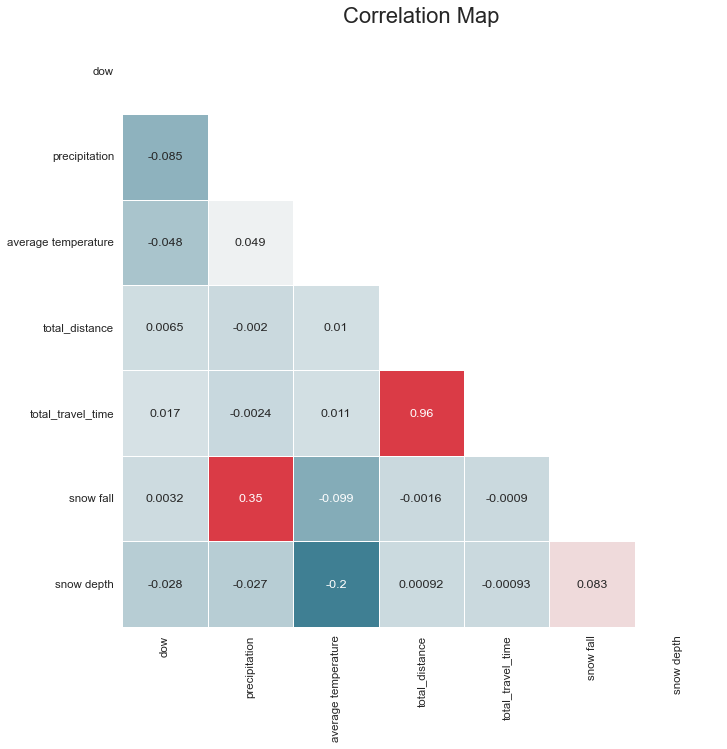

In [16]:
corr_features = ['dow','precipitation','average temperature','total_distance','total_travel_time','snow fall','snow depth']
corr = train.loc[:,corr_features].corr()
plt.figure(figsize = (11,11))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_context("paper",font_scale=1.3)
sns.set_style('white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,annot = True,square = True,cmap = cmap,mask = mask,linewidths=0.5,vmax = 0.3,cbar = False)
plt.title('Correlation Map',fontsize = 22)
plt.show()

## Exploring better ...

c:\users\nicholas\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


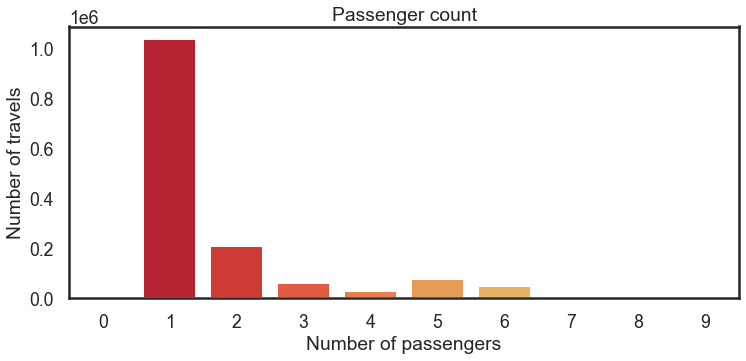

In [17]:
passengers = train.passenger_count.value_counts()
sns.set_context('poster',font_scale = 0.8)
plt.figure(figsize = (12,5))
sns.barplot(passengers.index,passengers.values,palette = 'YlOrRd_r')
plt.xlabel('Number of passengers')
plt.ylabel('Number of travels')
plt.title('Passenger count')
plt.show()

As the last plot showed us, it looks like its more likely that a taxi travel will carry only 1 or 2 person .

## Weather interference in Taxi trips
Analysing our correlation map its very clear that weather features apparently dont showed any correlation with our variables of interest, but as matter of fact we are gonna explore a few more the way that weather variables can relate with total_travel_time

In [18]:
## SNOW DEPTH PARSING
train['snow depth'] = round(train['snow depth'])
snow_tt = train.groupby('snow depth')['total_travel_time'].mean()

## PRECIPITATION PARSING
train['cprecipitation'] = pd.cut(train.precipitation,10,labels = False)
prec_tt = train.groupby('cprecipitation')['total_travel_time'].mean()

## AVERAGE TEMP PARSING
train['ctemp'] = pd.cut(train['average temperature'],10)
train['ctemp'] = train.ctemp.map(lambda x : round(x.mid))
temp_tt = train.groupby('ctemp')['total_travel_time'].mean()

## SNOW FALL PARSING
train['snow fall']  = train['snow fall'].astype(np.int32).map({2:1,27:1,0:0,1:1})
snowf_tt = train.groupby('snow fall')['total_travel_time'].mean()

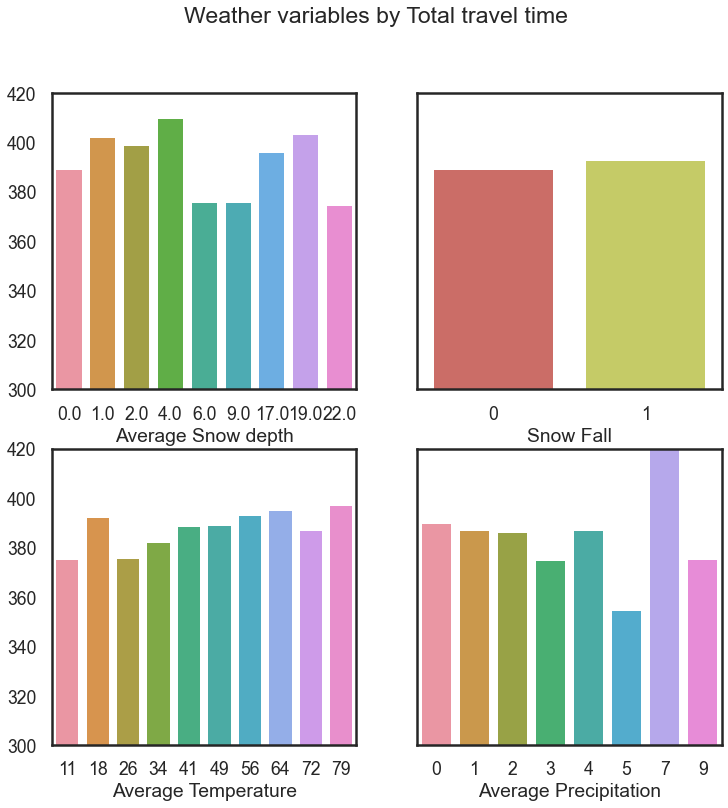

In [19]:
sns.set_palette(sns.color_palette("hls"))

fig,axes = plt.subplots(2,2,figsize = (12,12),sharey = True)
axes = np.array(axes).flatten()

fig.suptitle('Weather variables by Total travel time')
sns.barplot(x = snow_tt.index,y = snow_tt.values,ax = axes[0])
sns.barplot(x = snowf_tt.index,y = snowf_tt.values,ax = axes[1])
sns.barplot(x = temp_tt.index,y = temp_tt.values,ax = axes[2])
sns.barplot(x = prec_tt.index,y = prec_tt.values,ax = axes[3])

axes[0].set_xlabel('Average Snow depth')
axes[1].set_xlabel('Snow Fall')
axes[2].set_xlabel('Average Temperature')
axes[3].set_xlabel('Average Precipitation')

plt.setp(axes, ylim=(300,420))
plt.show()

## Weekly relationships

We have already seen lot of relationships between features and hour of the day, but now its time to see if we can find some relation between days of week and some variables.

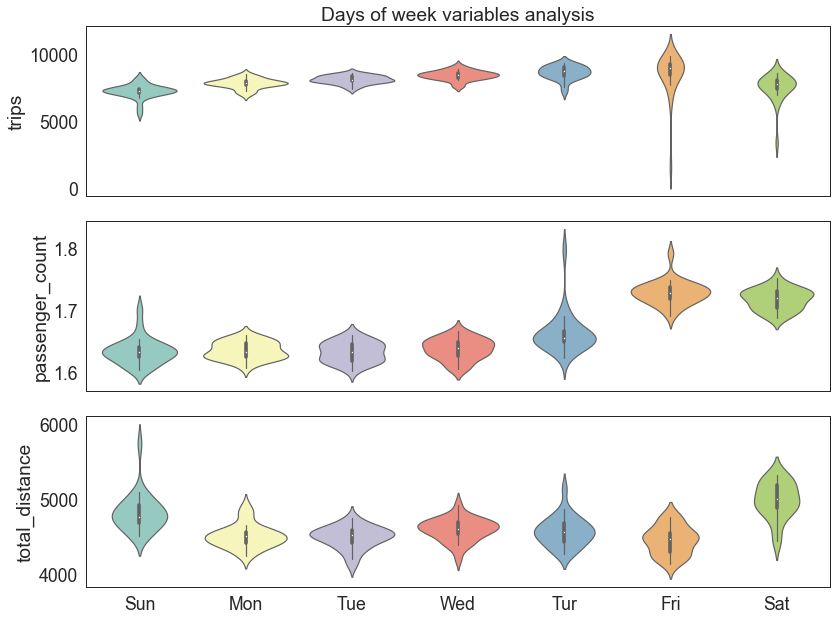

In [20]:
sns.set_context('paper',font_scale = 2)

fig,axes = plt.subplots(3,1,figsize = (12,9),sharex = True)
features = [['trips','Trips by day of week'],['passenger_count','Passengers by day of week'],['total_distance','Total distance by day of week']]
axes = np.array(axes).flatten()

axes[0].set_title('Days of week variables analysis')
for ax,feature in zip(axes,features):
    sns.violinplot(x = 'dow',y = feature[0],data = grouped,ax = ax,palette = 'Set3')
    #ax.set_title(feature[1])
    ax.set_xlabel('')
    
plt.setp(axes, xticks= grouped.dow.sort_values().unique(), xticklabels=['Sun','Mon','Tue','Wed','Tur','Fri','Sat'])
plt.tight_layout()

# Training the Model

Now we can start the ML part, lets start by importing the required tools

In [21]:
from sklearn.model_selection import ShuffleSplit as ss
from sklearn.model_selection import cross_val_score as cvs
from sklearn.preprocessing import LabelEncoder

Declaring some function we are gonna use

In [22]:
""" 
The Haversine formula calculates the shortest distance between two points,
on a sphere using their latitudes and longitudes measured along the surface. 
"""
def haversine(row):
    lon1 = row['pickup_longitude']
    lat1 = row['pickup_latitude']
    lon2 = row['dropoff_longitude']
    lat2 = row['dropoff_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6369 * c
    return km

""" 
This function will calculate the direction of the trips given the coordinates.
"""
def get_direction(row):
    lat_1 = row['pickup_latitude']
    long_1 = row['pickup_longitude']
    lat_2 = row['dropoff_latitude']
    long_2 = row['dropoff_longitude']
    
    AVG_EARTH_RADIUS = 6371  # in km
    long_delta_rad = np.radians(long_2 - long_1)
    lat_1, long_1, lat_2, long_2 = map(np.radians, (lat_1, long_1, lat_2, long_2))
    y = np.sin(long_delta_rad) * np.cos(lat_2)
    x = np.cos(lat_1) * np.sin(lat_2) - np.sin(lat_1) * np.cos(lat_2) * np.cos(long_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

""" 
Error function used to evaluate our model.
"""
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

Aplying distance and direction functions to our datasets

In [23]:
train["distance"] = train.apply(haversine,axis=1)
test["distance"] = test.apply(haversine,axis=1)

train["direction"] = train.apply(get_direction,axis=1)
test["direction"] = test.apply(get_direction,axis=1)

In [24]:
le = LabelEncoder()

train["store_and_fwd_flag"] = le.fit_transform(train["store_and_fwd_flag"])
test["store_and_fwd_flag"] = le.fit_transform(test["store_and_fwd_flag"])

Selecting the features we are gonna use and declaring our X and y

In [25]:
features = ["vendor_id","passenger_count","pickup_longitude","pickup_latitude",
           "dropoff_longitude","dropoff_latitude","store_and_fwd_flag","day",
           "dow","hour","average temperature","precipitation","snow fall",
           "snow depth","total_distance","total_travel_time","distance","direction"]

train = train[train.trip_duration<90000]

X = train[features]
y = train.trip_duration.values

Loading our Xgboost model and evaluating it with cross validation

In [27]:
reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=10)

cv = ss(n_splits=2, test_size=0.2, random_state=0)

print(cvs(reg, X, y, cv=cv,scoring=rmsle))

Number predicted less than 0: (61,)
Number predicted less than 0: (52,)
[0.52672978 0.52562048]


Lets train our model and predict the competition results!

In [28]:
reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

Lets explore the importance of the features in our model

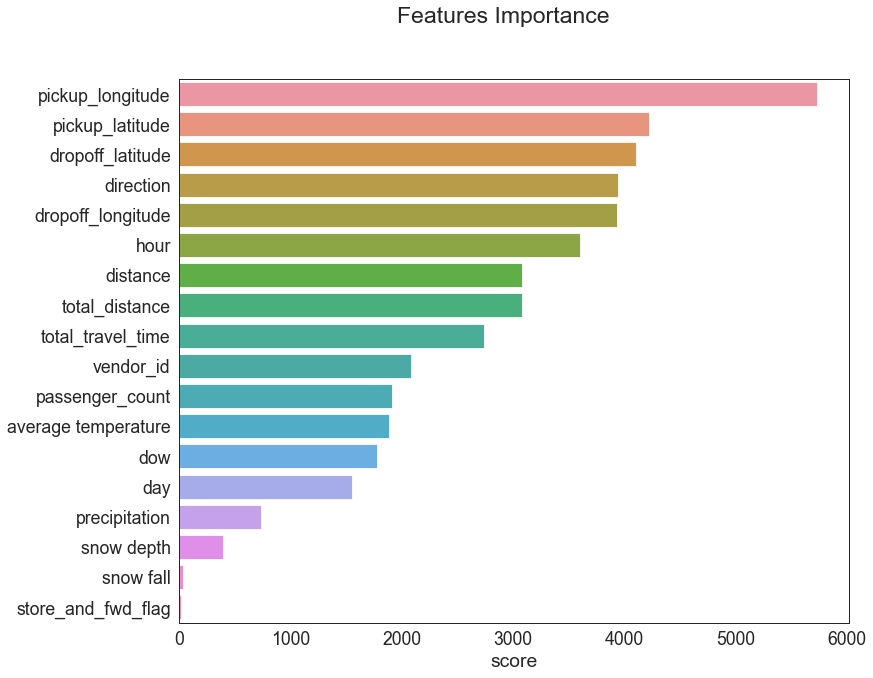

In [36]:
features_importance = reg.get_booster().get_score(importance_type='weight')
data = pd.DataFrame(data=features_importance.values(), index=features_importance.keys(), columns=["score"]).sort_values(by = "score", ascending=False)

fig = plt.figure(figsize = (12,10))
fig.suptitle('Features Importance')
sns.barplot(x = data.score,y = data.index)
plt.show()

In [30]:
X_test = test[features]
predicted = reg.predict(X_test)
test['trip_duration'] = predicted
test[['id','trip_duration']].to_csv('Taxi_sub.csv',index = False)

Thats it! We are done!